In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import h5py
import json
from utils import make_nice_plots
from tqdm import tqdm
make_nice_plots()

In [2]:
origin_dict = {}

post_path = '/net/vdesk/data2/pouw/MRP/mockdata_analysis/darksirenpop/jsons/posterior_samples_mock_v7.json'
with open(post_path) as f:
    posterior_samples_dictionary = json.load(f)

for key, filename in posterior_samples_dictionary.items():
    with h5py.File(filename, 'r') as f:
        origin_dict[key] = f['mock']['truths']['from_agn'][()].astype(bool)


In [21]:
cw_pagn = np.load('cweighted_pagn_sky_v17.npy')
palt = np.load('palt_sky_v17.npy')
cw_palt = np.load('cweighted_palt_sky_v17.npy')
origins = np.array([val for val in origin_dict.values()])

# remove_outlier = cw_pagn < 1e19
# cw_pagn = cw_pagn[remove_outlier]
# palt = palt[remove_outlier]
# cw_palt = cw_palt[remove_outlier]
# origins = origins[remove_outlier]

In [22]:
def get_colors(origin_dict):
    colors = np.zeros(len(origin_dict), dtype=str)
    for i, value in enumerate(origin_dict.values()):
        if value:
            colors[i] = 'blue'
        else:
            colors[i] = 'red'
    return colors

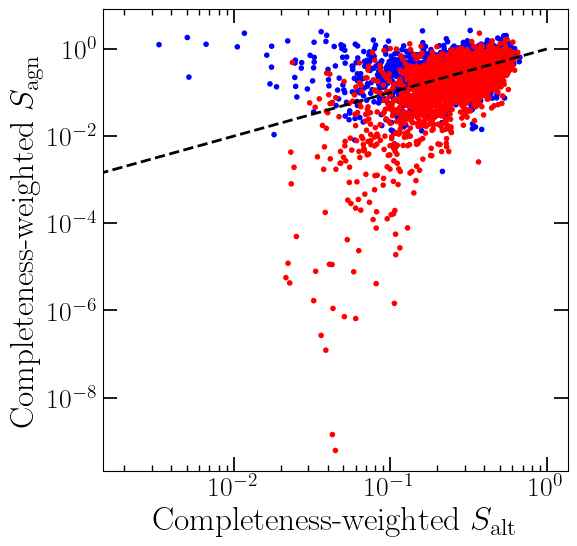

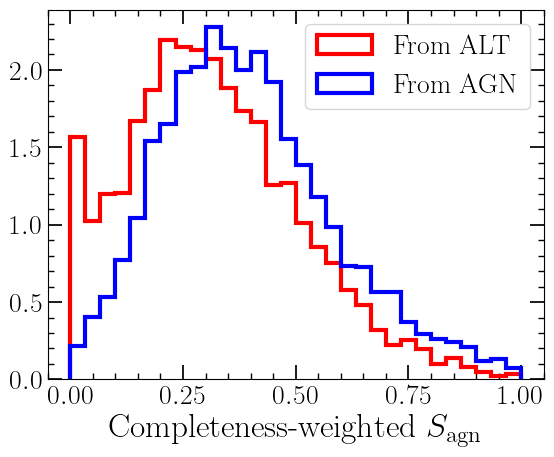

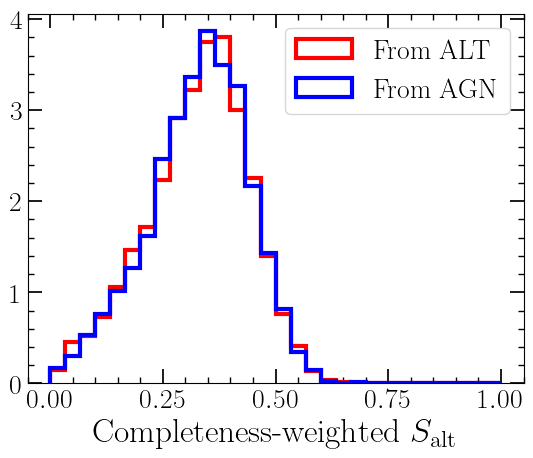

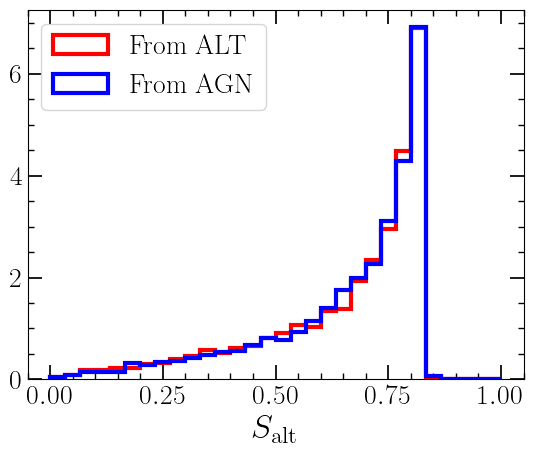

In [23]:
xmin = 0  # min(np.min(pagn), np.min(palt))
xmax = 1  # max(np.max(pagn), np.max(palt))
xx = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(6,6))
plt.scatter(cw_palt, cw_pagn, marker='.', color=get_colors(origin_dict))
plt.plot(xx, xx, color='black', linestyle='dashed', linewidth=2)
# plt.semilogy()
plt.loglog()
plt.xlabel(r'Completeness-weighted $S_{\rm alt}$')
plt.ylabel(r'Completeness-weighted $S_{\rm agn}$')
# plt.savefig('evidence_v8.pdf', bbox_inches='tight')
plt.show()

edges = np.linspace(xmin, xmax, 31)
plt.figure()
plt.hist(cw_pagn[~origins], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(cw_pagn[origins], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'Completeness-weighted $S_{\rm agn}$')
plt.show()

plt.figure()
plt.hist(cw_palt[~origins], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(cw_palt[origins], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'Completeness-weighted $S_{\rm alt}$')
plt.show()

plt.figure()
plt.hist(palt[~origins], bins=edges, density=True, histtype='step', color='red', linewidth=3, label='From ALT')
plt.hist(palt[origins], bins=edges, density=True, histtype='step', color='blue', linewidth=3, label='From AGN')
# plt.semilogx()
plt.legend()
plt.xlabel(r'$S_{\rm alt}$')
plt.show()


In [24]:
# Removing non-informative GWs
selec = (cw_pagn != 0) & (~np.isnan(cw_pagn))
print(np.sum(selec))
print(np.sum(np.isnan(cw_pagn)))


9978
0


In [25]:
# origins = origins[selec]
# cw_pagn = cw_pagn[selec]
# cw_palt = cw_palt[selec]
# palt = palt[selec]

In [26]:
# def compute_credible_interval(x_ax, llh, cl
#                               ):

#     cdf = np.cumsum(llh)
#     cdf /= cdf[-1]

#     low = np.interp((1-cl)/2, xp=cdf, fp=x_ax)
#     high = np.interp((1+cl)/2, xp=cdf, fp=x_ax)
    
#     return low, high

# low, high = compute_credible_interval(log_llh_x_ax, llh, 0.68)
# print(low, high)

# print(high - estimated_fagns[0])
# print(estimated_fagns[0] - low)


Chunking...


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:02<00:00, 16.87it/s]


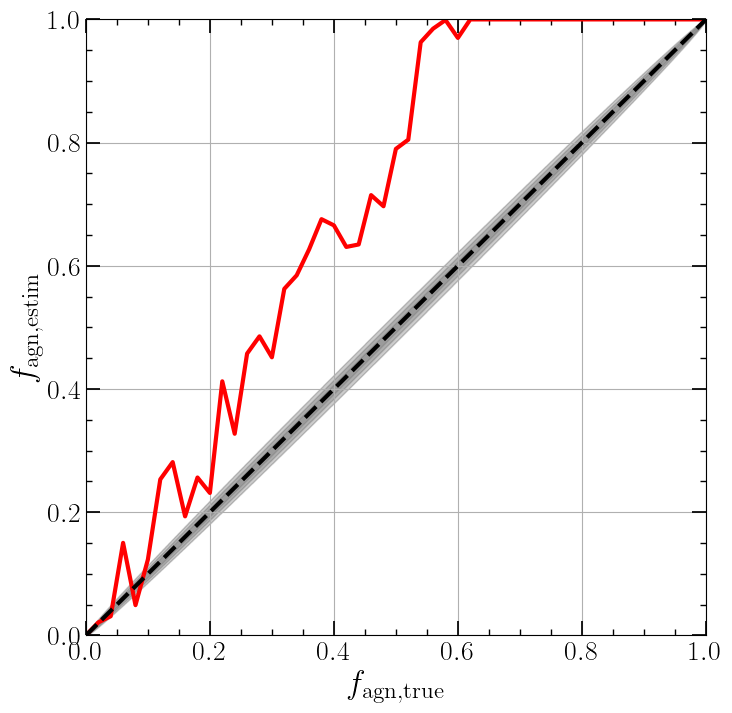

In [27]:
use_N_gws = 4000
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                   # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 1., calc_logllh_at_N_points)

estimated_fagns = np.zeros((N_true_fagns, calc_logllh_at_N_points))
lowers = np.zeros((N_true_fagns, calc_logllh_at_N_points))
uppers = np.zeros((N_true_fagns, calc_logllh_at_N_points))

## These two lines are for making the underlying truth equal to the actual realization of that truth
use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
true_fagns = use_N_agn_events / use_N_gws
# true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
# use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn
use_N_alt_events = use_N_gws - use_N_agn_events
realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

agn_events = origins
alt_events = ~origins

agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]  # TODO: DO WE NEED TO * 0.75?
total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
total_prob_alt = palt[idx].T[np.newaxis,...]

gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn
if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):

    print('Chunking...')

    log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
    for i in tqdm(range(int(use_N_gws / gw_chunk_size))):
        gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
        cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
        cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
        alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

        for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
            llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
            fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
            fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
            fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
            alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

            log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
            log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
else:
    log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
    log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )  

log_llh_denominator = 0
log_llh = log_llh_numerator - log_llh_denominator
max_log_llh = np.max(log_llh, axis=0)
estimated_fagns = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

#### Not sure about errors yet ####

# # Calculating 68% CL
# below_threshold = log_llh >= (max_log_llh - 0.5)
# # Get first and last occurrence of True values along axis 0
# first_valid = np.argmax(below_threshold, axis=0)
# last_valid = log_llh_x_ax.shape[0] - 1 - np.argmax(below_threshold[::-1], axis=0)
# lowers = estimated_fagns - log_llh_x_ax[first_valid]
# uppers = log_llh_x_ax[last_valid] - estimated_fagns

# lowers = np.zeros(N_true_fagns)
# uppers = np.zeros(N_true_fagns)
# for i, llh in enumerate(log_llh.T):
#     low_fagn, up_fagn = compute_credible_interval(log_llh_x_ax, llh)
#     lowers[i], uppers[i] = estimated_fagns[i] - low_fagn, up_fagn - estimated_fagns[i]
#     break

####################################

plt.figure(figsize=(8,8))
plt.plot(true_fagns, estimated_fagns, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
# plt.fill_between(true_fagns, estimated_fagns - lowers, estimated_fagns + uppers, color='red', alpha=0.3)

CI = np.linspace(0, 1, 1001)
for ci, alpha in zip([0.68, 0.95, 0.997], [0.1, 0.15, 0.2]):
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, use_N_gws, CI) / use_N_gws
    upper = binom.ppf(edge_of_bound, use_N_gws, CI) / use_N_gws
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(CI, lower, upper, alpha=alpha, color='k')

plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
# plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()



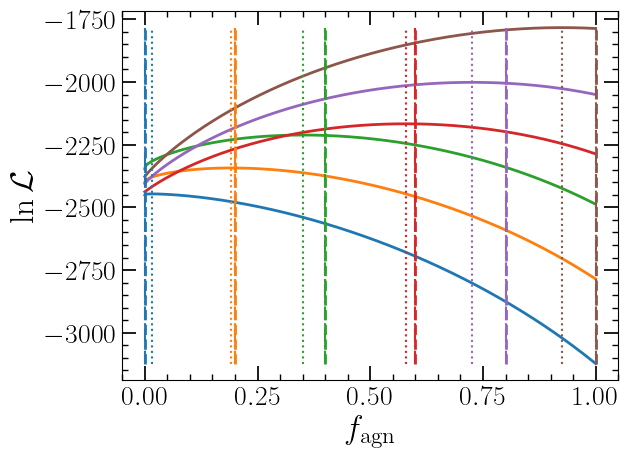

In [ ]:
plt.figure()
ymin = np.inf
ymax = -np.inf
ax_factor = 1.1
colors = []
every = 10
for i, llh in enumerate(log_llh.T[::every]):

    low, high = np.min(llh), np.max(llh)
    if ymin > low:
        ymin = low
    if ymax < high:
        ymax = high

    p = plt.plot(log_llh_x_ax, llh, linewidth=2, linestyle='solid', label='Total log-likelihood')
    c = colors.append( p[0].get_color() )

plt.vlines(true_fagns[::every], ymin, ymax, color=colors, linestyle='dashed', linewidth=2, label=r'True $f_{\rm agn}$')
plt.vlines(realized_fagns[::every], ymin, ymax, color=colors, linestyle='dashdot', label=r'Realized $f_{\rm agn}$')
plt.vlines(estimated_fagns[::every], ymin, ymax, color=colors, linestyle='dotted', label=r'Estimated $f_{\rm agn}$')
# plt.legend()
# plt.ylim(ymin / ax_factor, ax_factor * ymax)
plt.xlabel(r'$f_{\rm agn}$')
plt.ylabel(r'$\ln \mathcal{L}$')
plt.show()


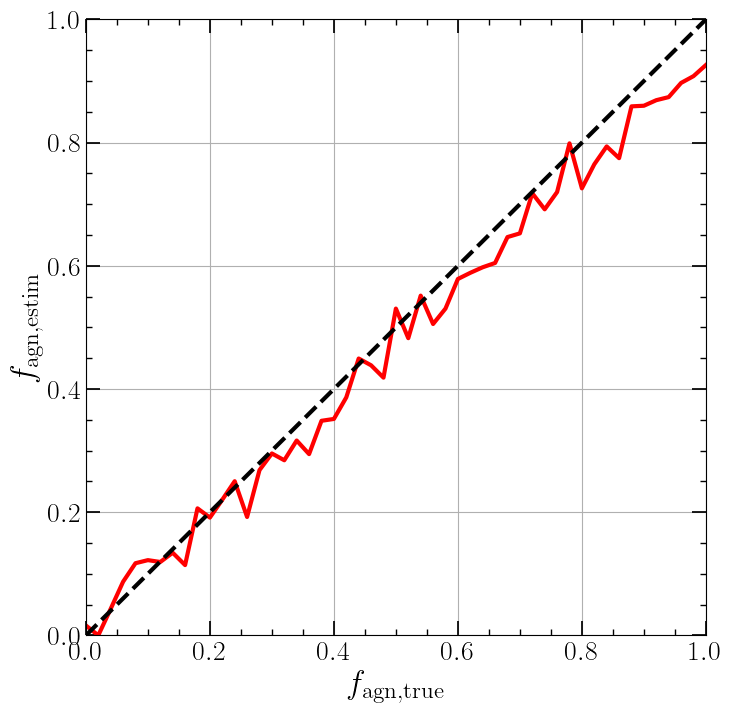

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(true_fagns, estimated_fagns, color='red', linewidth=3)
# plt.fill_between(true_fagns, estimated_fagns - lowers, estimated_fagns + uppers, color='red', alpha=0.3)
# plt.errorbar(true_fagns, estimated_fagns, yerr=np.array([lowers, uppers]), capsize=3, color='red', linestyle='')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
# plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
# plt.savefig('output/plots/ppplot.pdf', bbox_inches='tight')
plt.show()
